# Data Exploration
1. [Zeitbezogene Features hinzufügen](#1)
1. [Fehlende Werte untersuchen](#2)
1. [Datensatz beschränken](#3)
1. [Betrachtung von Ausreißern](#4)
1. [Feature Importance](#5)
1. [Saisonalität und Trends](#6)
1. [Korrelation der Features](#7)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3

RED = '#FF3247'
GREEN = '#31CC31'
BLUE = '#0f6df0'

print("Setup complete")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setup complete


In [2]:
df = pd.read_csv('../input/2024-01-18/cleaned_features.csv')
df.timestamp = pd.to_datetime(df.timestamp)

df.describe()

,dataid,timestamp,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,wellpump1,winecooler1,use,construction_year,n_residents,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity
count,87581.000000,87581,77474.000000,8386.000000,0.0,8684.000000,0.0,25670.000000,8362.000000,34622.000000,...,0.0,0.0,87368.000000,87581.000000,87581.000000,87581.000000,78821.000000,87561.000000,87561.000000,87561.000000
mean,5344.325219,2018-07-02 10:33:06.677475840,0.474819,0.060127,NaN,0.038220,NaN,0.010393,0.001780,0.052040,...,NaN,NaN,1.448548,1997.997831,2.500108,8.199610,193.766279,20.153042,20.658318,0.700174
min,661.000000,2018-01-01 00:00:00,-0.012750,-0.018250,NaN,0.000000,NaN,-0.001000,-0.001000,-0.001000,...,NaN,NaN,0.000000,1950.000000,0.000000,4.000000,154.590000,-8.660000,-13.580000,0.130000
25%,3456.000000,2018-04-02 05:00:00,0.000250,-0.005250,NaN,0.002250,NaN,0.002000,0.000000,0.007250,...,NaN,NaN,0.543500,2006.000000,2.000000,6.000000,159.790000,13.440000,13.440000,0.540000
50%,5746.000000,2018-07-02 11:00:00,0.004000,-0.004500,NaN,0.023000,NaN,0.004250,0.000000,0.019000,...,NaN,NaN,0.995750,2007.000000,2.000000,9.000000,185.810000,21.760000,22.170000,0.740000
75%,7800.000000,2018-10-01 16:00:00,0.728750,-0.003250,NaN,0.024000,NaN,0.023750,0.001500,0.071250,...,NaN,NaN,1.943000,2008.000000,3.000000,10.000000,213.680000,26.680000,28.270000,0.880000
max,9922.000000,2018-12-31 23:00:00,4.146500,1.310250,NaN,1.303750,NaN,0.843250,0.065500,0.604750,...,NaN,NaN,14.804500,2009.000000,5.000000,11.000000,260.130000,41.990000,42.340000,1.000000
std,2907.495781,NaN,0.768621,0.189653,NaN,0.082397,NaN,0.013292,0.004697,0.069516,...,NaN,NaN,1.293153,19.729855,1.284649,2.271668,35.678789,9.227060,10.390382,0.211481


<a id="1"></a>
## 1. Zeitbezogene Features hinzufügen

In [3]:
df['hour'] = df.timestamp.dt.hour
df['wday'] = df.timestamp.dt.dayofweek  # 0 = Montag, 6 = Sonntag
df['day'] = df.timestamp.dt.day
df['month'] = df.timestamp.dt.month
df['is_off_day'] = (df.is_holiday | df.wday.isin([5, 6]))

df.sample(5)

,dataid,timestamp,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,total_area,outdoor_temp,app_outdoor_temp,humidity,is_holiday,hour,wday,day,month,is_off_day
34469,4031,2018-12-08 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02200,...,213.68,6.89,3.98,0.95,False,5,5,8,12,True
57610,6139,2018-07-31 05:00:00,0.58875,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,260.13,25.61,26.37,0.82,False,5,1,31,7,False
20785,3456,2018-05-17 01:00:00,0.38825,NaN,NaN,NaN,NaN,0.024,NaN,0.00800,...,159.79,25.22,25.57,0.68,False,1,3,17,5,False
32806,4031,2018-09-29 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05475,...,213.68,22.31,23.06,0.94,False,22,5,29,9,True
84015,9922,2018-08-05 10:00:00,0.00025,-0.0025,NaN,NaN,NaN,NaN,NaN,0.00500,...,213.68,28.07,31.40,0.74,False,10,6,5,8,True


<a id="2"></a>
## 2. Fehlende Werte untersuchen

In [4]:
# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

# Prozentsatz der fehlenden Werte für jede Spalte berechnen
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

oven2               	99.99%
outsidelights_plugs1	90.45%
bathroom2           	90.45%
air2                	90.42%
kitchen2            	90.42%
lights_plugs4       	90.09%
airwindowunit1      	90.08%
bedroom3            	90.01%
garage1             	90.01%
furnace2            	89.99%
utilityroom1        	80.87%
kitchen1            	80.45%
venthood1           	80.45%
bedroom2            	80.10%
refrigerator2       	80.09%
range1              	80.05%
bathroom1           	70.69%
dryg1               	70.54%
office1             	70.09%
livingroom1         	60.96%
bedroom1            	60.47%
car1                	60.28%
lights_plugs3       	60.12%
kitchenapp2         	50.78%
disposal1           	50.25%
oven1               	40.94%
lights_plugs2       	40.16%
kitchenapp1         	30.80%
lights_plugs1       	30.15%
refrigerator1       	20.81%
microwave1          	20.80%
drye1               	20.34%
air1                	11.54%
clotheswasher1      	10.82%
total_area          	10.00%
furnace1            

Was auffällt: Da es z.T. mehrere Badezimmer, Schlafzimmer, usw. gibt, entsteht die Problematik, dass die Spalten für die Werte z.B. eines 2. oder 3. Schlafzimmers bei den meisten Häusern leer sind, da nicht vorhanden. Um dies zu umgehen, werden die Spalten im Folgenden jeweils zusammengefasst

In [5]:
# Identifizieren der Spaltenpaare
spaltenpaare = {}
for spalte in df.columns:
    if spalte[-1].isdigit():
        basisname = spalte[:-1]
        if basisname in spaltenpaare:
            spaltenpaare[basisname].append(spalte)
        else:
            spaltenpaare[basisname] = [spalte]

# Zusammenfassen der Spalten und Erstellen neuer Spalten
for basisname, spalten in spaltenpaare.items():
    df[basisname] = df[spalten].sum(axis=1, skipna=True, min_count=1)

# Entfernen der ursprünglichen Spalten
for spalten in spaltenpaare.values():
    df.drop(columns=spalten, inplace=True)

<a id="3"></a>
## 3. Datensatz beschränken
Beschränkung auf den Haushalt mit den meisten Features und Datenpunkten

Gründe für die Beschränkung:
* Datensatz ist zu groß für die zur Verfügung stehende Rechenleistung
* Es soll STLF für einen einzelnen Haushalt durchgeführt werden, Transfer-Learning ist nicht vorgesehen

In [6]:
# Funktion, um die Anzahl der Features und Datenpunkte zu zählen
def count_info(group):
    n_features = group.notnull().any().sum()
    n_rows = len(group)
    return pd.Series({'n_features': n_features, 'n_rows': n_rows})

# Anwenden der Funktion auf jeden Haushalt
group_info = df.groupby('dataid').apply(count_info).sort_values(by=['n_features', 'n_rows'], ascending=[False, False])
best_id = group_info.index[0]

group_info

,n_features,n_rows
dataid,,
1642,31,8760
3456,30,8760
6139,30,8760
5746,29,8760
7800,28,8760
9922,28,8760
661,27,8760
4031,27,8760
9278,26,8760


In [7]:
# Haushalt auswählen
df = df[df.dataid == best_id]

# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

venthood        	4.45%
clotheswasher   	4.45%
utilityroom     	4.45%
refrigerator    	4.45%
microwave       	4.45%
livingroom      	4.45%
kitchenapp      	4.45%
furnace         	4.45%
dryg            	4.45%
dishwasher      	4.45%
bathroom        	4.45%
oven            	1.63%
drye            	1.63%
car             	1.63%
air             	1.63%
use             	1.12%
humidity        	0.02%
app_outdoor_temp	0.02%
outdoor_temp    	0.02%


In [8]:
# Imputation durch Forward Fill
df = df.sort_values(by='timestamp').reset_index(drop=True)
df['use_is_na'] = df.use.isna()
df = df.ffill().fillna(0)

<a id="4"></a>
## 4. Betrachtung von Ausreißern

In [9]:
df.min()

timestamp           2018-01-01 00:00:00
use                                 0.0
outdoor_temp                      -8.66
app_outdoor_temp                 -13.58
humidity                           0.13
is_holiday                        False
hour                                  0
wday                                  0
day                                   1
month                                 1
is_off_day                        False
air                                 0.0
bathroom                         -0.001
car                            -0.00875
clotheswasher                  -0.00275
dishwasher                          0.0
drye                           -0.00575
dryg                            -0.0005
furnace                             0.0
kitchenapp                     -1.48575
livingroom                          0.0
microwave                           0.0
oven                              0.007
refrigerator                        0.0
utilityroom                    -0.21375


### Warum ist der Stromverbrauch teilweise negativ

Ein negativer Stromverbrauch bei Haushaltsgeräten ist ungewöhnlich und kann auf verschiedene Ursachen hinweisen. Hier sind einige mögliche Erklärungen:

1. Fehler in der Messung: Dies ist die wahrscheinlichste Ursache. Messfehler können durch defekte oder falsch kalibrierte Messgeräte, schlechte Verbindungen oder andere technische Probleme entstehen.
2. Rückeinspeisung ins Netz: In Haushalten mit Solaranlagen oder anderen Formen der Energieerzeugung kann es vorkommen, dass Energie ins Netz zurückgespeist wird. Wenn das Messgerät nicht korrekt zwischen verbrauchter und erzeugter Energie unterscheidet, könnte dies als negativer Verbrauch angezeigt werden.
3. Software- oder Anzeigefehler: Manchmal können Softwareprobleme oder Anzeigefehler in digitalen Messsystemen zu falschen Werten führen.
4. Netzbedingte Schwankungen: In seltenen Fällen können Schwankungen im Stromnetz zu ungewöhnlichen Messwerten führen.

Da die Werte nur minimal negativ sind, handelt es sich vermutlich um einen Messfehler

In [10]:
appliances = ['air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye', 'dryg', 'furnace','kitchenapp',
              'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']

# Negative Werte auf 0 setzen
for column in appliances:
    df[column] = df[column].apply(lambda x: 0 if x < 0 else x)

df.min()

timestamp           2018-01-01 00:00:00
use                                 0.0
outdoor_temp                      -8.66
app_outdoor_temp                 -13.58
humidity                           0.13
is_holiday                        False
hour                                  0
wday                                  0
day                                   1
month                                 1
is_off_day                        False
air                                 0.0
bathroom                            0.0
car                                 0.0
clotheswasher                       0.0
dishwasher                          0.0
drye                                0.0
dryg                                0.0
furnace                             0.0
kitchenapp                          0.0
livingroom                          0.0
microwave                           0.0
oven                              0.007
refrigerator                        0.0
utilityroom                         0.0


In [11]:
df.max()

timestamp           2018-12-31 23:00:00
use                              9.2035
outdoor_temp                      41.99
app_outdoor_temp                  42.34
humidity                            1.0
is_holiday                         True
hour                                 23
wday                                  6
day                                  31
month                                12
is_off_day                         True
air                              2.8165
bathroom                          0.093
car                             3.39625
clotheswasher                     0.306
dishwasher                      0.89925
drye                              0.003
dryg                              0.572
furnace                         0.72275
kitchenapp                      0.78925
livingroom                      0.98525
microwave                         0.555
oven                             1.8565
refrigerator                    0.22225
utilityroom                     0.00275


### Der maximale Stromverbrauch für das gesamte Haus `use` wirkt sehr hoch

In [12]:
max_indices = df.nlargest(5, 'use').index
max_idx = max_indices[2]

start_idx = max_idx - 3
end_idx = max_idx + 4

cols_to_show = appliances + ['use', 'hour']
df[cols_to_show][start_idx:end_idx]

,air,bathroom,car,clotheswasher,dishwasher,drye,dryg,furnace,kitchenapp,livingroom,microwave,oven,refrigerator,utilityroom,venthood,use,hour
4215,0.87475,0.00100,0.00400,0.00025,0.00100,0.0,0.08600,0.47425,0.00175,0.08375,0.06200,0.00825,0.15125,0.0,0.00000,1.84775,15
4216,1.00700,0.00075,0.00350,0.27750,0.00075,0.0,0.00050,0.42050,0.00150,0.46525,0.00325,0.00825,0.20650,0.0,0.01175,2.55050,16
4217,1.56800,0.00075,0.08800,0.12500,0.00075,0.0,0.00175,0.50800,0.00000,0.55225,0.00250,0.00775,0.15700,0.0,0.02800,4.16850,17
4218,2.51275,0.00050,3.38075,0.00050,0.00100,0.0,0.00200,0.65825,0.00000,0.39600,0.20325,0.00800,0.15900,0.0,0.02900,8.78775,18
4219,2.46600,0.00100,3.37500,0.06950,0.00100,0.0,0.00000,0.65650,0.00225,0.17500,0.11150,0.00850,0.15475,0.0,0.00000,7.21350,19
4220,2.40200,0.00100,3.33325,0.00000,0.00100,0.0,0.04375,0.66175,0.00200,0.38575,0.00325,0.00825,0.14825,0.0,0.00300,7.18675,20
4221,2.11025,0.00250,0.10025,0.13275,0.00100,0.0,0.07825,0.63175,0.00200,0.35000,0.00325,0.00825,0.14100,0.0,0.00000,3.78125,21


Der beobachtete maximale Wert für den Stromverbrauch stellt keinen Ausreißer oder Messfehler dar. Vielmehr lässt sich diese Spitze im Stromverbrauch durch alltägliche Verhaltensmuster erklären. Typischerweise steigt der Stromverbrauch in Haushalten zu Zeiten an, wenn Menschen von der Arbeit nach Hause kommen. Dies ist oft am späten Nachmittag oder frühen Abend der Fall.

Die Zunahme des Stromverbrauchs korreliert mit alltäglichen Aktivitäten wie dem Einschalten von Lichtern, Haushaltsgeräten und Unterhaltungselektronik. Zusätzlich kann die Nutzung von Heiz- oder Kühlgeräten, abhängig von der Jahreszeit, zu diesem Zeitpunkt ebenfalls ansteigen.

Ein weiteres Indiz dafür, dass es sich bei den Spitzenwerten nicht um Messfehler handelt, ist das erkennbare Muster im Verbrauch: ein Anstieg kurz vor dem Maximum und ein Abfall danach. Diese beobachteten Muster spiegeln typische Verhaltensweisen und Gewohnheiten im Haushaltsstromverbrauch wider und bestätigen die Plausibilität der gemessenen Werte.

Größter Faktor: Auto --> E-Auto, das geladen wird, wenn Bewohner nach Hause kommen, und nach 3 Stunden voll geladen ist

<a id="5"></a>
## 5. Feature Importance
### Mutual Information

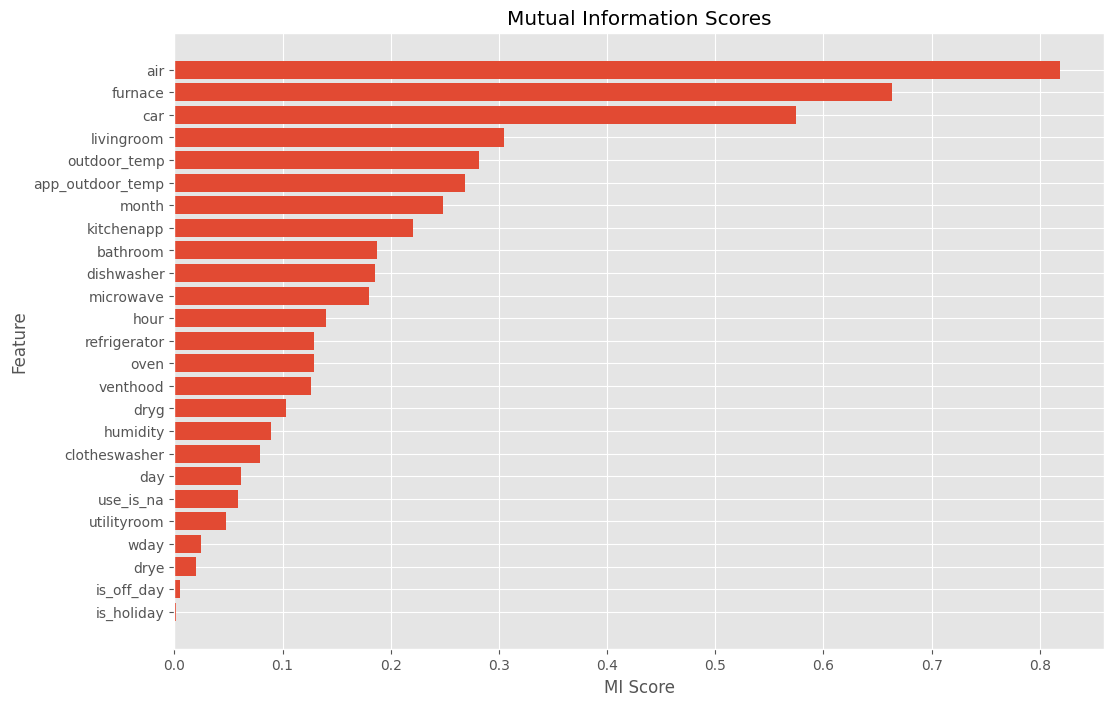

In [13]:
y = df.use
X = df.drop(['timestamp', 'use'], axis=1)

mi_values = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_values, index=X.columns).sort_values(ascending=True)

width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.figure(figsize=(12, 8))
plt.barh(width, mi_scores)
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         8760 non-null   datetime64[ns]
 1   use               8760 non-null   float64       
 2   outdoor_temp      8760 non-null   float64       
 3   app_outdoor_temp  8760 non-null   float64       
 4   humidity          8760 non-null   float64       
 5   is_holiday        8760 non-null   bool          
 6   hour              8760 non-null   int32         
 7   wday              8760 non-null   int32         
 8   day               8760 non-null   int32         
 9   month             8760 non-null   int32         
 10  is_off_day        8760 non-null   bool          
 11  air               8760 non-null   float64       
 12  bathroom          8760 non-null   float64       
 13  car               8760 non-null   float64       
 14  clotheswasher     8760 n

In [15]:
# Als csv-Datei speichern
df.to_csv('exploratory_analysis.csv', index=False)

<a id="6"></a>
## 6. Saisonalität und Trends

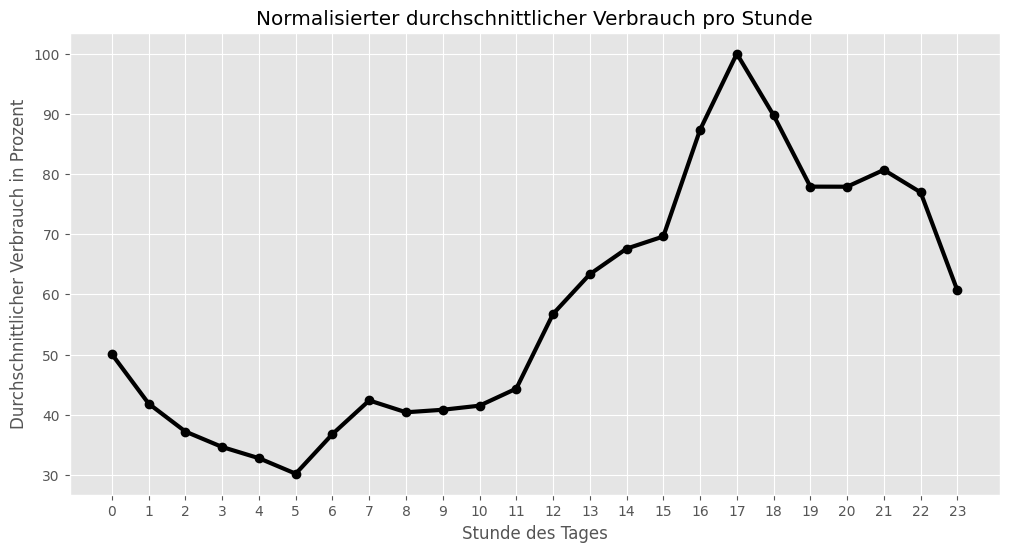

In [16]:
# Gruppieren nach Stunde und Berechnen des Durchschnitts
hourly_avg = df.groupby('hour').use.mean()

# Normalisieren
max_value = hourly_avg.max()
hourly_avg_normalized = (hourly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_normalized.index, hourly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Stunde')
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittlicher Verbrauch in Prozent')
plt.xticks(range(24))
plt.show()

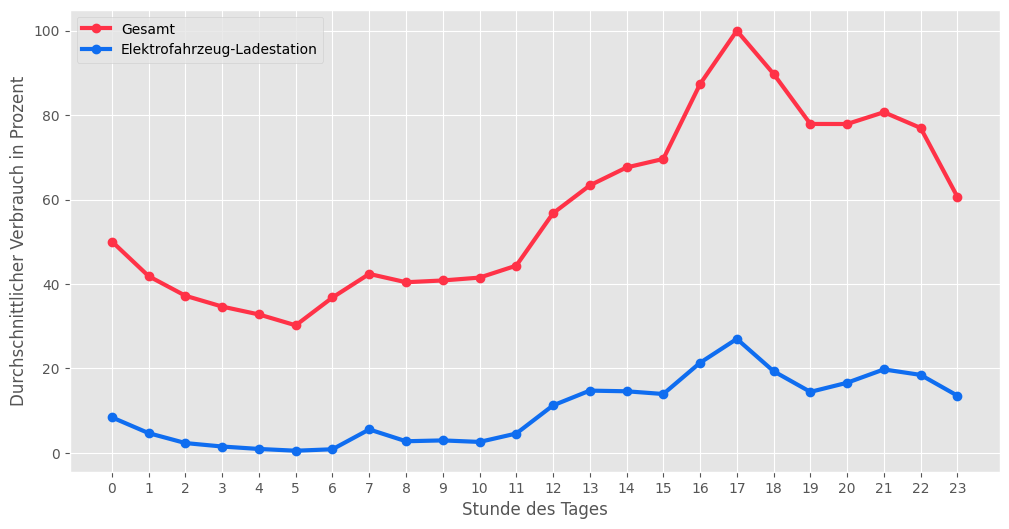

In [17]:
# Gruppieren nach Stunde und Berechnen des Durchschnitts
hourly_avg_car = df.groupby('hour').car.mean()

# Normalisieren
hourly_avg_car_normalized = (hourly_avg_car / max_value) * 100

# Auswahl eines konkreten Tages
# sample_timestamp = df.iloc[max_idx].timestamp
# sample_df = df[df.timestamp.dt.date == sample_timestamp.date()]
# date_str = sample_timestamp.strftime('%d.%m.%Y')

# hourly_sample = sample_df.groupby('hour').use.mean()
# hourly_sample_car = sample_df.groupby('hour').car.mean()

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg_normalized.values, color=RED, marker='o', label='Gesamt')
# plt.plot(hourly_avg.index, hourly_sample.values, color='#0f6df0', marker='o', label=f'Gesamtverbrauch am {date_str}')
plt.plot(hourly_avg.index, hourly_avg_car_normalized.values, color=BLUE, marker='o', label='Elektrofahrzeug-Ladestation')
# plt.plot(hourly_avg.index, hourly_sample_car.values, color='#31CC31', marker='o', label=f'Verbrauch der Ladestation am {date_str}')
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittlicher Verbrauch in Prozent')
plt.xticks(range(24))
plt.legend(loc='upper left')
plt.savefig('hourly_plot.svg', bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

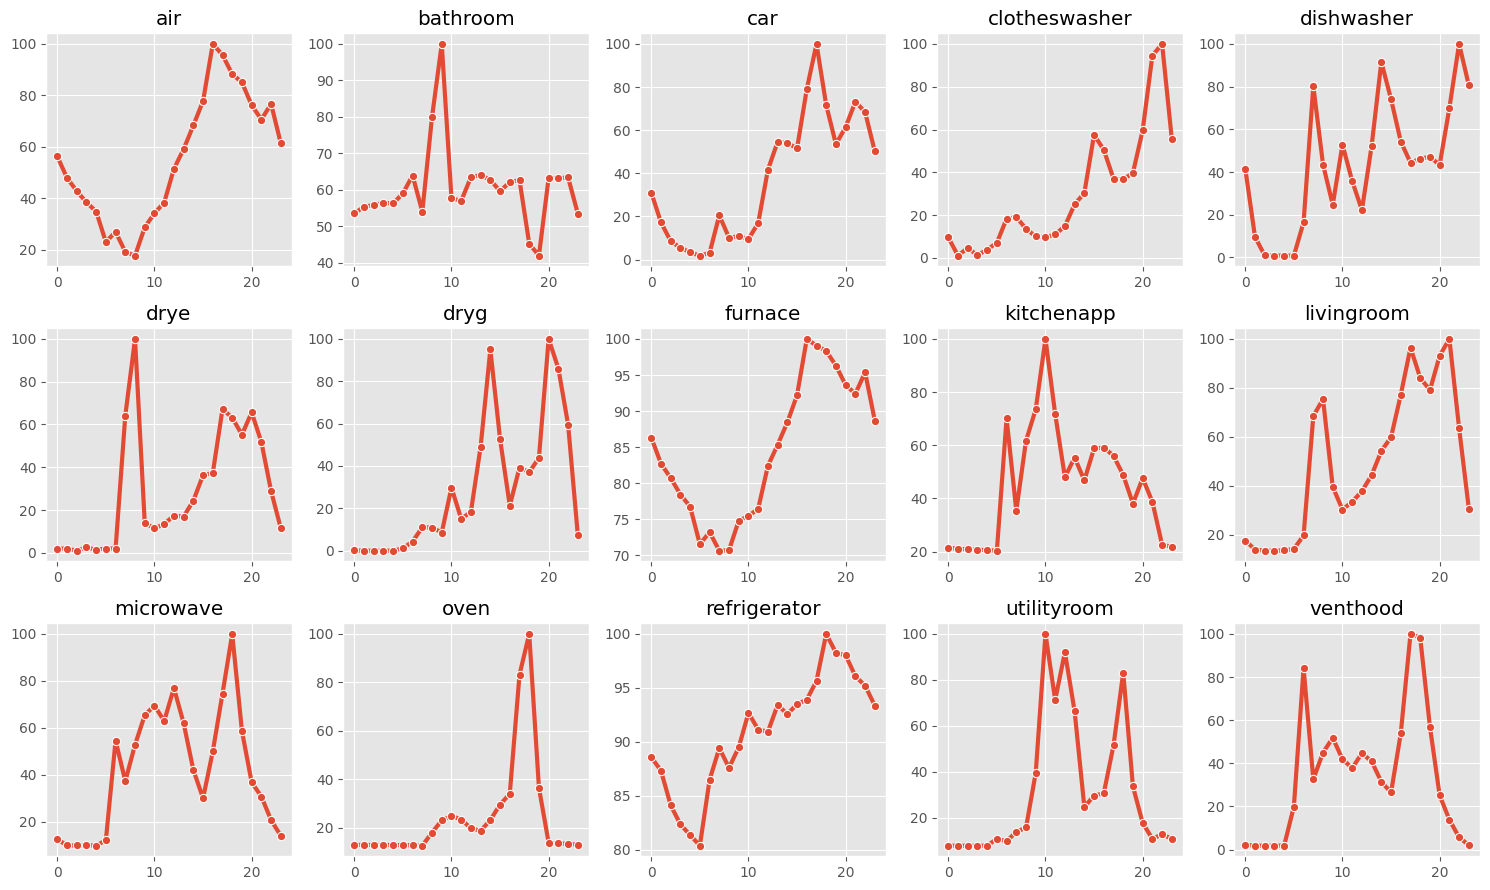

In [18]:
num_cols = 5
num_rows = 3

plt.figure(figsize=(3 * num_cols, 3 * num_rows))

for i, column in enumerate(appliances):
    plt.subplot(num_rows, num_cols, i + 1)  # Nummer der Zeilen, Nummer der Spalten, aktueller Subplot

    hourly_avg = df.groupby('hour')[column].mean()
    max_value = hourly_avg.max()
    hourly_avg_normalized = (hourly_avg / max_value) * 100
    sns.lineplot(x=hourly_avg_normalized.index, y=hourly_avg_normalized.values, marker='o')

    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

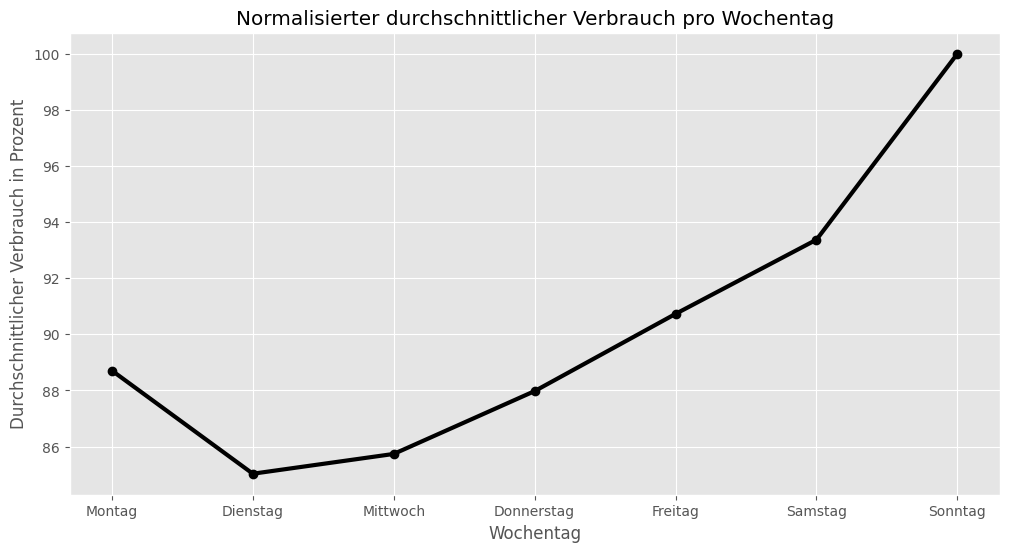

In [19]:
# Gruppieren nach Wochentag und Berechnen des Durchschnitts
weekly_avg = df.groupby('wday').use.mean()

# Normalisieren
max_value = weekly_avg.max()
weekly_avg_normalized = (weekly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg_normalized.index, weekly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittlicher Verbrauch in Prozent')
plt.xticks(range(7), ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
plt.show()

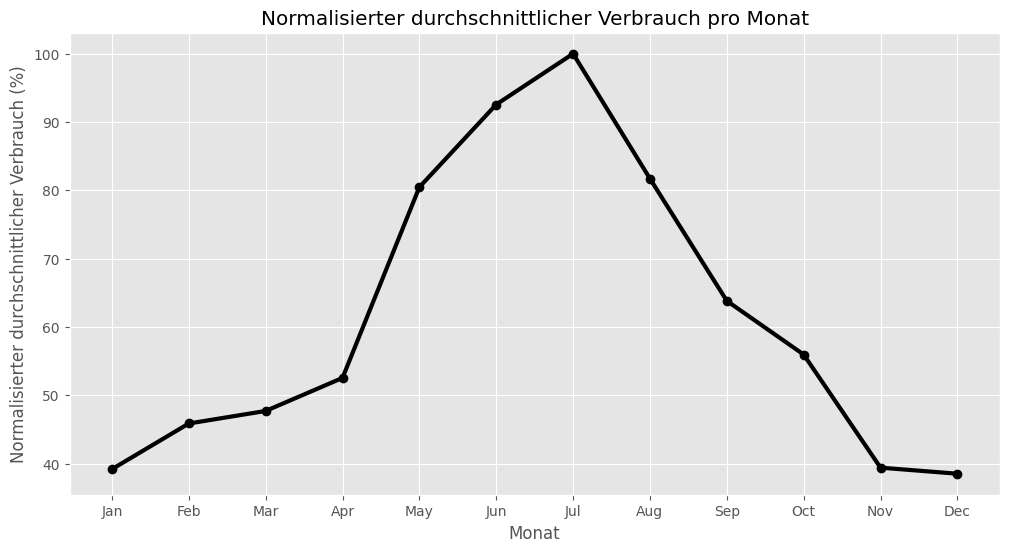

In [20]:
# Monatsabkürzungen erstellen
df['month_abbr'] = df.timestamp.dt.strftime('%b')

# Gruppieren nach Monat und Berechnen des Durchschnitts
monthly_avg = df.groupby('month').use.mean()
monthly_avg.index = df.month_abbr.unique()

# Normalisieren
max_value = monthly_avg.max()
monthly_avg_normalized = (monthly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_normalized.index, monthly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Monat')
plt.xlabel('Monat')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.show()

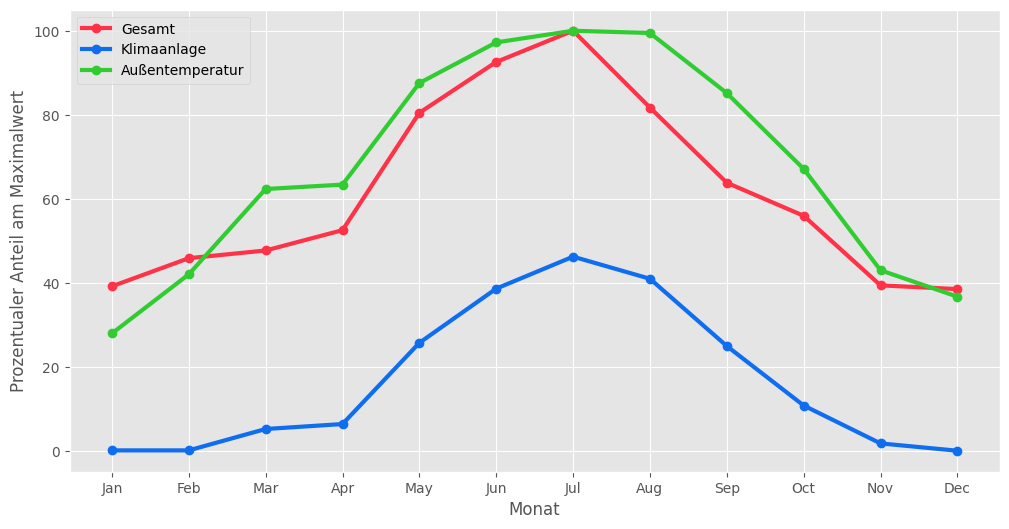

In [21]:
# Gruppieren nach Monat und Berechnen des Durchschnitts
monthly_avg_air = df.groupby('month').air.mean()
monthly_avg_temp = df.groupby('month').outdoor_temp.mean()

# Normalisieren
max_value_ec = monthly_avg.max()
max_value_temp = monthly_avg_temp.max()
monthly_avg_normalized = (monthly_avg / max_value_ec) * 100
monthly_avg_air_normalized = (monthly_avg_air / max_value_ec) * 100
monthly_avg_temp_normalized = (monthly_avg_temp / max_value_temp) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg_normalized.values, color=RED, marker='o', label='Gesamt')
plt.plot(monthly_avg.index, monthly_avg_air_normalized.values, color=BLUE, marker='o', label='Klimaanlage')
plt.plot(monthly_avg.index, monthly_avg_temp_normalized.values, color=GREEN, marker='o', label='Außentemperatur')
plt.xlabel('Monat')
plt.ylabel('Prozentualer Anteil am Maximalwert')
plt.legend(loc='upper left')
plt.savefig('monthly_plot.svg', bbox_inches='tight')
plt.show()

<a id="7"></a>
## 7. Korrelation der Features

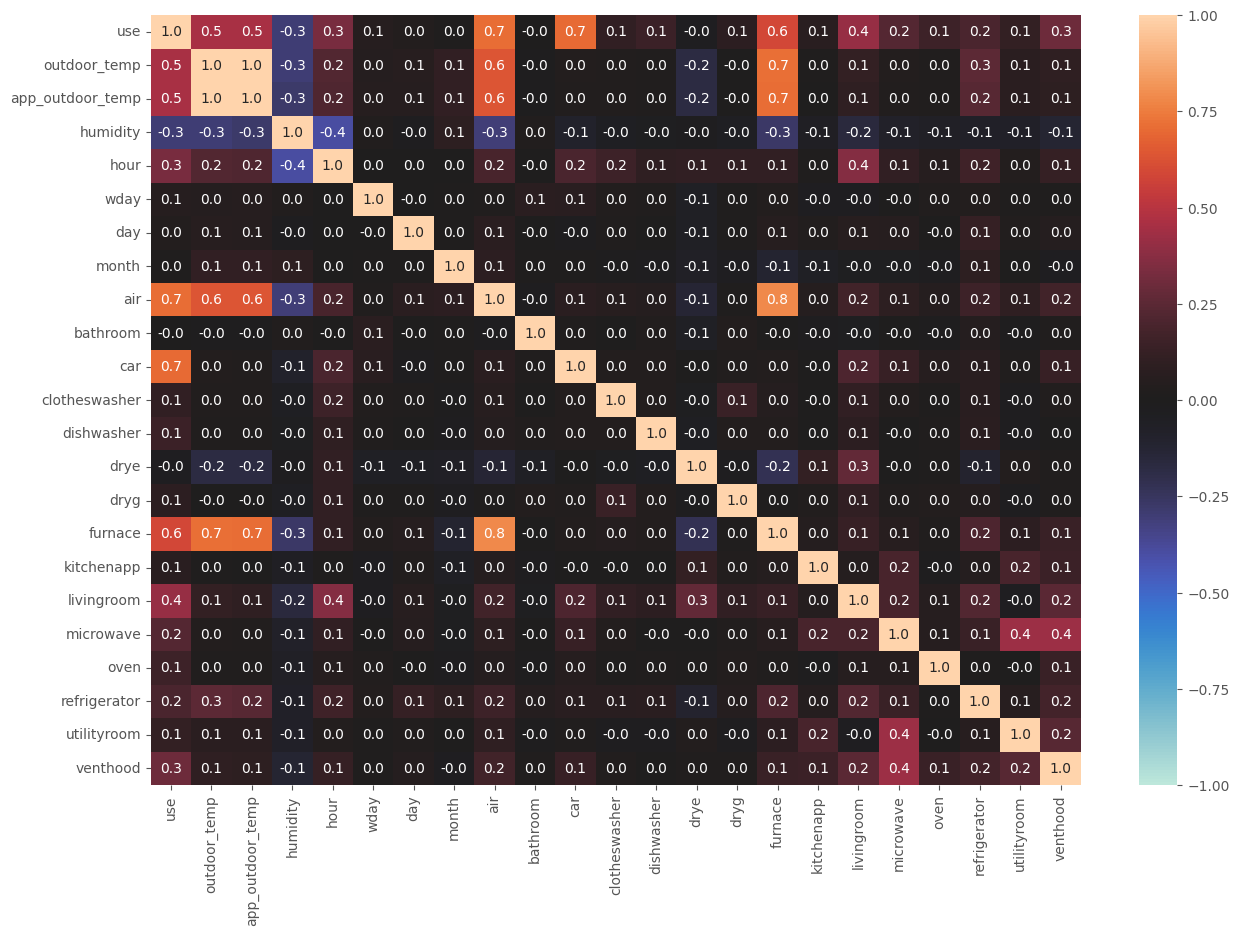

In [22]:
fig = plt.subplots(figsize=(15, 10))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".1f", vmin=-1.0, vmax=1.0, center=0)
plt.show()

In [23]:
# Schleife durch die Korrelationsmatrix und extrahiere Paare mit (positiver oder negativer) Korrelation >= 0,7
threshold = 0.7
correlation_pairs = []

for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) >= threshold:
            feature1 = corr.columns[i]
            feature2 = corr.columns[j]
            correlation_value = corr.iloc[i, j]
            correlation_pairs.append(f"{feature1} - {feature2}: {correlation_value:.1f}")

# Ausgabe der gefundenen Paare
for pair in correlation_pairs:
    print(pair)

use - air: 0.7
outdoor_temp - app_outdoor_temp: 1.0
outdoor_temp - furnace: 0.7
app_outdoor_temp - furnace: 0.7
air - furnace: 0.8


Hier sind Erklärungen für die jeweiligen Korrelationen basierend auf realen Weltbeispielen und plausiblen Annahmen:

1. `use - air: 0.7`
   - Begründung: Diese Korrelation könnte darauf hindeuten, dass der Energieverbrauch in Haushalten (`use`) tendenziell mit der Nutzung von Klimaanlagen (`air`) zusammenhängt. Ein höherer Energieverbrauch könnte auf eine intensivere Nutzung von Klimaanlagen hinweisen, insbesondere in wärmeren Perioden.

2. `use - car: 0.7`
   - Begründung: Die Korrelation zwischen dem Energieverbrauch (`use`) und der Anzahl der Autos (`car`) könnte darauf hinweisen, dass Haushalte mit mehr Autos tendenziell auch mehr Energie verbrauchen. Dies könnte auf längere Fahrten oder eine größere Abhängigkeit von Fahrzeugen für den täglichen Bedarf hinweisen.

3. `outdoor_temp - app_outdoor_temp: 1.0`
   - Begründung: Diese perfekte positive Korrelation deutet darauf hin, dass `app_outdoor_temp` und `outdoor_temp` identische oder sehr eng miteinander verknüpfte Messungen sind, möglicherweise durch direkte Ableitung oder sehr genaue Schätzungen der Außentemperatur.

6. `air - furnace: 0.8`
   - Begründung: Die fortbestehende hohe Korrelation zwischen Klimaanlagen (`air`) und Heizungen (`furnace`) deutet darauf hin, dass Haushalte, die intensiv Klimaanlagen nutzen, auch dazu neigen, ihre Heizungen intensiv zu nutzen. Dies könnte auf eine generelle Präferenz für die aktive Regulierung der Innentemperatur hinweisen, unabhängig von der Jahreszeit.